In [1]:
!pip install wikipedia

  Using cached wikipedia-1.4.0-py3-none-any.whl

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import wikipedia

# 위키피디아 언어 설정 (영어 위키피디아)
wikipedia.set_lang("en")

# 테스트할 문서 제목
test_title = "The Starry Night"

try:
    # 문서 내용 가져오기
    page = wikipedia.page(test_title)
    print("Wikipedia page found!")
    print("Title:", page.title)
    print("Summary:", page.summary[:500]) # 500자까지만 출력

except Exception as e:
    print(f"Error fetching Wikipedia page: {e}")

Wikipedia page found!
Title: The Starry Night
Summary: The Starry Night, often called simply Starry Night, is an oil-on-canvas painting by the Dutch Post-Impressionist painter Vincent van Gogh. Painted in June 1889, it depicts the view from the east-facing window of his asylum room at Saint-Rémy-de-Provence, just before sunrise, with the addition of an imaginary village. It has been in the permanent collection of the Museum of Modern Art in New York City since 1941, acquired through the Lillie P. Bliss Bequest. Described as a "touchstone of modern a


In [3]:
import wikipedia
import os
import re

# 위키피디아에서 가져올 문서 목록
wiki_titles = [
    "Water Lilies (Monet series)",
    "The Starry Night",
    "Where Do We Come From? What Are We? Where Are We Going?",
    "The Card Players",
    "Bedroom in Arles",
    "Café Terrace at Night",
    "Women in the Garden",
    "Impression, Sunrise",
    "The Kiss (Klimt)",
]

# 다운로드한 파일을 저장할 폴더 생성
output_folder = "wiki_downloads"
os.makedirs(output_folder, exist_ok=True)

def download_wikipedia_page(title):
    """위키피디아 문서를 다운로드하여 텍스트 파일로 저장"""
    try:
        page = wikipedia.page(title)
        title = title.replace(" ", "_")
        file_path = os.path.join(output_folder, f"{title}.txt")
        with open(file_path, "w", encoding="utf-8") as f:
            f.write(page.content)
            print(f"Saved Wikipedia article: {file_path}")
        return file_path
    except Exception as e:
        print(f"Error downloading page '{title}': {str(e)}")
        return None

In [4]:
import requests
from urllib.parse import quote

def get_wikidata_id(title):
    """위키피디아 문서에서 위키데이터 ID 조회"""

    # 문서 제목을 URL에 사용할 수 있도록 인코딩 (공백 등 특수문자 처리)
    encoded_title = quote(title)
    wiki_api_url = f"https://en.wikipedia.org/w/api.php?action=query&titles={encoded_title}&prop=pageprops&format=json"
    # 요청을 보낼 때 User-Agent 없이 요청하면 차단됨
    headers = {"User-Agent": "Mozilla/5.0"}
    # 위키피디아 API에 GET 요청을 보내고 응답을 받아옴
    response = requests.get(wiki_api_url, headers=headers)
    
    # 응답 상태가 200이면 정상이지만, 아니면 오류 처리
    if response.status_code != 200:
        print(f"Failed to fetch Wikidata ID for {title}. HTTP Status: {response.status_code}")
        return None
    
    data = response.json()
    # JSON 데이터에서 'query' → 'pages' 키를 찾아 문서 정보 가져오기
    pages = data.get("query", {}).get("pages", {})
    # 페이지 정보에서 'pageprops' 내 'wikibase_item' 속성을 찾아 위키데이터 ID(QID) 추출
    for page_id, page_data in pages.items():
        if "pageprops" in page_data and "wikibase_item" in page_data["pageprops"]:
            return page_data["pageprops"]["wikibase_item"]
   
    return None

In [5]:
import hashlib

def get_md5_path(filename):
    # 파일명에서 공백을 제거하고 첫 글자를 소문자로 변환
    filename_normalized = filename.replace(' ', '_')

    # MD5 해시 생성
    md5 = hashlib.md5(filename_normalized.encode('utf-8')).hexdigest()
    return f"{md5[0]}/{md5[0:2]}/{filename_normalized}"

In [6]:
import requests

def get_infobox_image(wikidata_id):
    """위키데이터에서 대표 이미지 URL 가져오기"""
    if not wikidata_id:
        return None
    
    wikidata_url = f"https://www.wikidata.org/wiki/Special:EntityData/{wikidata_id}.json"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(wikidata_url, headers=headers)
    
    # 응답 상태가 200이면 정상이지만, 아니면 오류 처리
    if response.status_code != 200:
        print(f"Failed to fetch Wikidata data for {wikidata_id}. HTTP Status: {response.status_code}")
        return None
    
    # 응답 데이터를 JSON 형식으로 변환
    data = response.json()
    # 'entities' 딕셔너리에서 특정 Wikidata ID에 해당하는 데이터 가져오기
    entity = data.get("entities", {}).get(wikidata_id, {})
    # 'claims' 항목에서 속성 정보 가져오기 (각종 메타데이터 포함)
    claims = entity.get("claims", {})
    
    # 'P18' 속성이 존재하는지 확인 (P18은 대표 이미지 속성을 의미)
    if "P18" in claims:
        image_filename = claims["P18"][0]["mainsnak"]["datavalue"]["value"]
        # 이미지 파일명을 위키미디어 URL 형식으로 변환 (MD5 해싱 적용)
        md5_path = get_md5_path(image_filename)
        # 최종적으로 위키미디어 공용(Wikimedia Commons)에서 접근 가능한 이미지 URL 반환
        return f"https://upload.wikimedia.org/wikipedia/commons/{md5_path}"
    return None

In [7]:
import requests
from PIL import Image
from io import BytesIO

def download_image(url, title, max_size=800):
    if not url:
        print(f"No image found for {title}.")
        return None
    
    try:
        # PIL 라이브러리 임포트
        Image.MAX_IMAGE_PIXELS = None # DecompressionBomb 에러 방지
    
        headers = {"User-Agent": "Mozilla/5.0"}
        response = requests.get(url, headers=headers)
        response.raise_for_status()
    
        # 이미지 열기
        img = Image.open(BytesIO(response.content))
        
        # 원본 크기 확인
        width, height = img.size
        print(f"Original size: {width}x{height}")
        
        # 리사이징 필요 여부 확인
        if width > max_size or height > max_size:        
            # 비율 유지하면서 리사이징
            if width > height:
                new_width = max_size
                new_height = int(height * (max_size / width))
            else:
                new_height = max_size
                new_width = int(width * (max_size / height))
        
            try:
                # 고품질 리사이징 (LANCZOS)
                img.thumbnail((new_width, new_height), Image.Resampling.LANCZOS)
                print(f"Resized to: {new_width}x{new_height}")
            except Exception as e:
                print(f"Error during resize, trying with NEAREST resampling: {str(e)}")
                img.thumbnail((new_width, new_height), Image.Resampling.NEAREST)
        
        # 이미지 저장
        safe_title = sanitize_filename(title)
        image_path = os.path.join(output_folder, f"{safe_title}.jpg")
        
        # JPEG로 저장 (품질 85%)
        img.convert('RGB').save(image_path, 'JPEG', quality=85)
        print(f"Downloaded and saved image: {image_path}")
        return image_path
        
    except requests.exceptions.RequestException as e:
        print(f"Failed to download image for {title}. Error: {str(e)}")
        # 썸네일 URL이 실패하면 원본 URL로 재시도
        if "thumb" in url:
            original_url = url.split("/thumb/")[0] + "/" + url.split("/thumb/")[1].split("/")[0]
            print(f"Trying original URL: {original_url}")
            return download_image(original_url, title, max_size)
        return None
    except Exception as e:
        print(f"Error processing image for {title}. Error: {str(e)}")
        return None

In [8]:
def sanitize_filename(title):
    """파일명에서 특수문자를 제거하고 안전한 형식으로 변환"""
    return re.sub(r'[^a-zA-Z0-9_-]', '_', title)

In [9]:
for title in wiki_titles:
    text_path = download_wikipedia_page(title)
    
    if text_path:
        wikidata_id = get_wikidata_id(title)
        image_url = get_infobox_image(wikidata_id)
        download_image(image_url, title)

Saved Wikipedia article: wiki_downloads/Water_Lilies_(Monet_series).txt
Original size: 5472x3648
Resized to: 800x533
Downloaded and saved image: wiki_downloads/Water_Lilies__Monet_series_.jpg
Saved Wikipedia article: wiki_downloads/The_Starry_Night.txt
Original size: 30000x23756
Resized to: 800x633
Downloaded and saved image: wiki_downloads/The_Starry_Night.jpg
Saved Wikipedia article: wiki_downloads/Where_Do_We_Come_From?_What_Are_We?_Where_Are_We_Going?.txt
Original size: 3090x1175
Resized to: 800x304
Downloaded and saved image: wiki_downloads/Where_Do_We_Come_From__What_Are_We__Where_Are_We_Going_.jpg
Error downloading page 'The Card Players': Page id "the cards players" does not match any pages. Try another id!
Saved Wikipedia article: wiki_downloads/Bedroom_in_Arles.txt
Original size: 30000x23803
Resized to: 800x634
Downloaded and saved image: wiki_downloads/Bedroom_in_Arles.jpg
Saved Wikipedia article: wiki_downloads/Café_Terrace_at_Night.txt
Original size: 2864x3568
Resized to: 

In [10]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core import SimpleDirectoryReader
from llama_index.core.schema import ImageDocument
import os

OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

# 이미지 데이터 로딩
image_documents = SimpleDirectoryReader("wiki_downloads").load_data()

documents = []
for doc in image_documents:
    if isinstance(doc, ImageDocument):
        documents.append(doc)

# OpenAI 다중 모달 모델 설정
openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o-mini", api_key=OPENAI_API_KEY, max_new_tokens=1500
)

# 이미지 데이터를 텍스트로 변환
response_1 = openai_mm_llm.complete(
    prompt="이미지를 텍스트로 설명해주세요.",
    image_documents=documents[:2],
)

print(response_1)

첫 번째 이미지는 빈센트 반 고흐의 "아를의 침실"이라는 작품으로, 밝은 노란색 침대와 나무 바닥이 특징입니다. 방 안에는 테이블과 의자들이 있으며, 벽에는 여러 개의 그림이 걸려 있습니다. 창문은 열려 있고, 자연광이 방 안으로 들어옵니다.

두 번째 이미지는 "별이 빛나는 밤"이라는 작품으로, 밤하늘에 별들이 반짝이고 있습니다. 거리에는 카페와 사람들이 있으며, 건물들은 따뜻한 색조로 그려져 있습니다. 거리의 돌길과 나무들이 조화를 이루며, 전체적으로 생동감 있는 분위기를 자아냅니다.


In [11]:
!pip install qdrant-client
!pip install llama-index-vector-stores-qdrant

  Using cached qdrant_client-1.14.3-py3-none-any.whl.metadata (10 kB)
  Using cached grpcio-1.73.1-cp311-cp311-macosx_11_0_universal2.whl.metadata (3.8 kB)
  Using cached portalocker-2.10.1-py3-none-any.whl.metadata (8.5 kB)
  Using cached protobuf-6.31.1-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
  Using cached h2-4.2.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached hyperframe-6.1.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached hpack-4.1.0-py3-none-any.whl.metadata (4.6 kB)
Using cached qdrant_client-1.14.3-py3-none-any.whl (328 kB)
Using cached grpcio-1.73.1-cp311-cp311-macosx_11_0_universal2.whl (10.6 MB)
Using cached portalocker-2.10.1-py3-none-any.whl (18 kB)
Using cached protobuf-6.31.1-cp39-abi3-macosx_10_9_universal2.whl (425 kB)
Using cached h2-4.2.0-py3-none-any.whl (60 kB)
Using cached hpack-4.1.0-py3-none-any.whl (34 kB)
Using cached hyperframe-6.1.0-py3-none-any.whl (13 kB)

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update

In [12]:
import qdrant_client
from llama_index.vector_stores.qdrant import QdrantVectorStore

# 로컬 쿼드런트 벡터 스토어 생성
client = qdrant_client.QdrantClient(path="qdrant_mm_db")

In [13]:
# 텍스트 및 이미지 벡터 저장소 생성
text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)

In [14]:
!pip install git+https://github.com/openai/CLIP.git
!pip install llama-index-embeddings-clip

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/j6/8rrb63_s2nsc5rh381vvzng00000gn/T/pip-req-build-e9czjbkz
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/j6/8rrb63_s2nsc5rh381vvzng00000gn/T/pip-req-build-e9czjbkz
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached torch-2.7.1-cp311-none-macosx_11_0_arm64.whl.metadata (29 kB)
  Using cached torchvision-0.22.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached ftfy-6.3.1-py3-none-any.whl (44 kB)
Using 

In [15]:
from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.core.indices import MultiModalVectorStoreIndex

# 스토리지 컨텍스트 설정
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# 문서 데이터 로딩
documents = SimpleDirectoryReader("wiki_downloads").load_data()

# 멀티모달 벡터 인덱스 생성
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

/Users/gaheeyoon/llamaindex/ch01/ch01_env/lib/python3.11/site-packages/llama_index/vector_stores/qdrant/base.py:709: UserWarning: Payload indexes have no effect in the local Qdrant. Please use server Qdrant if you need payload indexes.
  self._client.create_payload_index(


In [16]:
# 텍스트 검색을 위한 설정
MAX_TOKENS = 100
retriever_engine = index.as_retriever(
    image_similarity_top_k=3
)

# 검색할 질문 입력
question = "Introduce representative works of Monet"
retrieval_results = retriever_engine.retrieve(question)
print(retrieval_results)

[NodeWithScore(node=TextNode(id_='2eb03fba-03a8-4c3f-ac58-284b1fc01b31', embedding=None, metadata={'file_path': '/Users/gaheeyoon/llamaindex/ch05/wiki_downloads/Water_Lilies_(Monet_series).txt', 'file_name': 'Water_Lilies_(Monet_series).txt', 'file_type': 'text/plain', 'file_size': 4497, 'creation_date': '2025-07-01', 'last_modified_date': '2025-07-01'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e7b08a7a-937d-47cf-a258-80f0d3485f23', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': '/Users/gaheeyoon/llamaindex/ch05/wiki_downloads/Water_Lilies_(Monet_series).txt', 'file_name': 'Water_Lilies_(Monet_series).txt', 'file_type': 'text/plain', 'file_size': 4497, 'creation_date': '2025-07-01', 'la

In [17]:
!pip install matplotlib

  Using cached matplotlib-3.10.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.4-cp311-cp311-macosx_10_9_universal2.whl.metadata (106 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp311-cp311-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp311-cp311-macosx_11_0_arm64.whl (254 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.58.4-cp311-cp311-macosx_10_9_universal2.whl (2.8 MB)
Using cached kiwisolver-1.4.8-cp311-cp311-macosx_11_0_arm64.whl (65 kB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [18]:
import matplotlib.pyplot as plt
from PIL import Image

def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

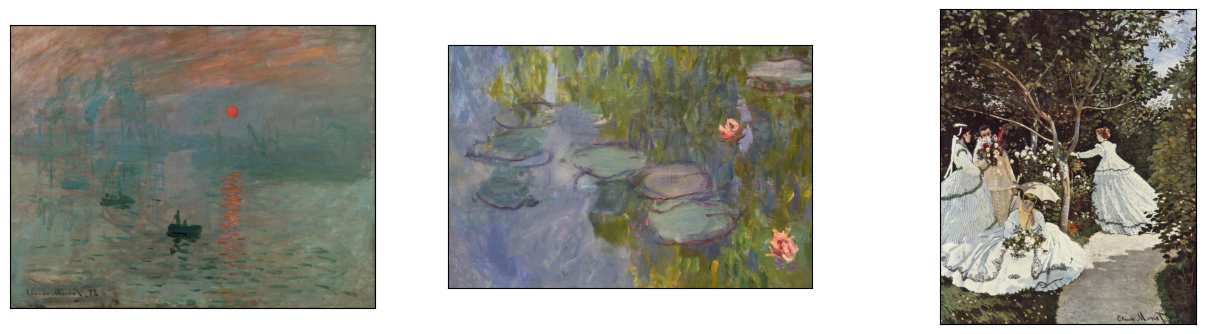

In [19]:
from llama_index.core.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])

# 검색된 이미지 출력
plot_images(retrieved_image)

In [20]:
result = index.as_query_engine(llm=openai_mm_llm).query("Introduce representative works of Claude Monet. Answer in Korean")
print(result.response)

클로드 모네의 대표적인 작품으로는 다음과 같은 두 가지가 있습니다.

1. **인상, 해돋이 (Impression, Sunrise)**: 이 작품은 모네가 르 아브르의 창밖에서 본 풍경을 그린 것으로, 인상주의라는 미술 운동의 이름을 탄생시킨 작품입니다. 해가 떠오르는 장면을 포착하여 빛과 색의 변화를 표현했습니다.

2. **수련 (Water Lilies)**: 이 시리즈는 모네가 자신의 정원에서 수련을 주제로 한 작품들로, 물의 반사와 빛의 변화를 아름답게 담아내고 있습니다. 다양한 색조와 질감을 사용하여 자연의 순간적인 아름다움을 표현했습니다. 

이 두 작품은 모네의 인상주의 스타일을 잘 보여주는 대표적인 예입니다.


In [21]:
from llama_index.core import PromptTemplate

# 개선된 프롬프트 템플릿 정의
qa_templeate_str = (
    "다음은 신뢰할 수 있는 출처로부터 추출한 관련 정보입니다.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "제공된 정보를 바탕으로 아래 질의에 대해 명확하고 구조적인 답변을 생성하세요.\n"
    "주어진 정보 외의 외부 지식에는 의존하지 마세요.\n"
    "답변은 구체적이고 유익하며 일관성 있게 작성해야 합니다.\n"
    "질문: {query_str}\n"
    "답변: "
)

qa_tmpl = PromptTemplate(qa_templeate_str)

query_engine = index.as_query_engine(
    llm=openai_mm_llm, text_qa_template=qa_tmpl
)

query_str = "클로드 모네에 대해 한국어로 좀 더 자세히 설명해주세요."
result = query_engine.query(query_str)
print(result.response)

클로드 모네(Claude Monet)는 19세기 프랑스의 화가로, 인상파(Impressionism) 운동의 주요 인물 중 한 명입니다. 그는 자연의 빛과 색을 포착하는 데 중점을 두었으며, 그의 작품은 주로 야외에서 그려졌습니다. 모네는 특히 수련(水蓮) 시리즈와 같은 작품으로 유명하며, 이는 그의 정원에서 자주 그린 주제입니다.

모네의 화풍은 빠른 붓질과 색의 조화를 통해 순간의 인상을 전달하는 데 중점을 두었습니다. 그는 빛의 변화에 따라 같은 장면을 여러 번 그려, 시간의 흐름과 자연의 변화를 표현했습니다. 그의 대표작 중 하나인 "수련" 시리즈는 이러한 접근 방식을 잘 보여줍니다.

모네는 또한 색채의 사용에 있어 혁신적이었으며, 그의 작품은 후에 많은 현대 화가들에게 영향을 미쳤습니다. 그의 예술적 기법은 인상파의 기초를 다졌고, 오늘날에도 여전히 많은 사랑을 받고 있습니다.


In [22]:
import os

wiki_titles = [
    "Nave nave moe",
]

output_folder = "wiki_downloads2"
os.makedirs(output_folder, exist_ok=True)

for title in wiki_titles:
    text_path = download_wikipedia_page(title)

    if text_path:
        wikidata_id = get_wikidata_id(title)
        image_url = get_infobox_image(wikidata_id)
        if image_url:
            print(f"해당 URL로부터 다운로드를 진행 중입니다: {image_url}")
            download_image(image_url, title)

Saved Wikipedia article: wiki_downloads2/Nave_nave_moe.txt
해당 URL로부터 다운로드를 진행 중입니다: https://upload.wikimedia.org/wikipedia/commons/9/95/Paul_Gauguin_068.jpg
Original size: 4356x3304
Resized to: 800x606
Downloaded and saved image: wiki_downloads2/Nave_nave_moe.jpg


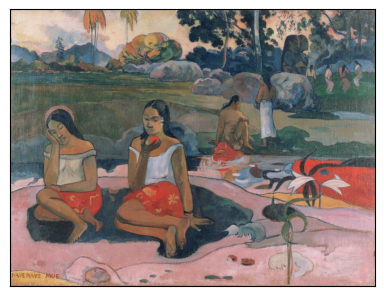

In [23]:
input_image = "wiki_downloads2/Nave_nave_moe.jpg"
plot_images([input_image])

In [24]:
from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core.indices import MultiModalVectorStoreIndex
import qdrant_client

# 만약 이미 이전 코드에서 생성된 client를 사용하는 것이라면 주석처리해야 합니다.
# client = qdrant_client.QdrantClient(path="qdrant_mm_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

documents = SimpleDirectoryReader("wiki_downloads").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

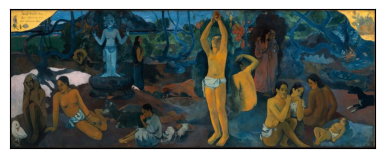

In [25]:
retriever_engine = index.as_retriever(image_similarity_top_k=1)
retrieval_results = retriever_engine.image_to_image_retrieve(
    "wiki_downloads2/Nave_nave_moe.jpg"
)
retrieved_images = []
for res in retrieval_results:
    retrieved_images.append(res.node.metadata["file_path"])

plot_images(retrieved_images)

In [26]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core.schema import ImageDocument
from llama_index.core.llms import ChatMessage

# 비교할 이미지 문서 준비
image_documents = [
    ImageDocument(image_path=input_image),
    ImageDocument(image_path=retrieved_images[0]),
]

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o-mini",
    api_key=OPENAI_API_KEY,
    max_new_tokens=1500
)

# 멀티모달 질의 수행
response = openai_mm_llm.complete(
    prompt="첫 번째 이미지의 화가를 알려주고, 같은 시대의 다른 화가 한 명과 그 대표 작품도 함께 소개해주세요.",
    image_documents=image_documents
)

# 결과 출력
print(response.text)

첫 번째 이미지는 폴 고갱(Paul Gauguin)의 작품입니다. 고갱은 19세기 후반 프랑스 인상파 화가로, 주로 타히티의 풍경과 원주율적인 삶을 주제로 한 작품으로 유명합니다.

같은 시대의 다른 화가로는 빈센트 반 고흐(Vincent van Gogh)를 들 수 있습니다. 반 고흐의 대표 작품 중 하나는 **"별이 빛나는 밤"**(Starry Night)입니다. 이 작품은 그의 감정과 내면의 고뇌를 표현한 것으로, 강렬한 색채와 독특한 붓질이 특징입니다.
